In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

In [9]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import geometry
from geopy.distance import geodesic
from tqdm import tqdm
import shapely.speedups
from quetzal.model import stepmodel
from quetzal.io import excel

# Preparation of the transport network.
## Saves PT networks with clustered nodes.
## Needs PT networks.

In [3]:
input_path = '../input_static/'
output_path = '../output/'
model_path = '../model/'

In [4]:
# Load scenario parameters
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

In [5]:
bus = stepmodel.read_json(input_path + 'de_pt_network_bus')

In [6]:
sm = stepmodel.read_json(input_path + 'de_pt_network')

In [7]:
# Make sure to use the right zones
z = stepmodel.read_json(model_path + 'de_zones')
z.zones['FID'] = z.zones['NUTS_ID']
sm.zones = gpd.GeoDataFrame(z.zones)
bus.zones = gpd.GeoDataFrame(z.zones)

## Test links and nodes for network integrity
Neccessary for any further steps

In [10]:
# FIRST: Set time of free-rider links
# Default velocity of 14 m/s for rail links
sm.links.loc[sm.links['time']==0, 'time'] = sm.links.loc[
    sm.links['time']==0, 'geometry'].apply(
        lambda l: int(geodesic(l.coords[0], l.coords[-1]).m)) / 14
# 8 m/s for bus links
bus.links.loc[bus.links['time']==0, 'time'] = bus.links.loc[
    bus.links['time']==0, 'geometry'].apply(
        lambda l: int(geodesic(l.coords[0], l.coords[-1]).m)) / 8

In [11]:
# Check nodeset integrity for later steps to work
try:
    sm.integrity_test_nodeset_consistency()
except AssertionError:
    print('Found {} orphan nodes'.format(len(sm.orphan_nodes)))
    sm.nodes.drop(sm.orphan_nodes, inplace=True)
    # Test integrity again
    sm.integrity_test_nodeset_consistency()

Found 5 orphan nodes
no road_links or road_nodes


In [12]:
# Test sequences
# Use an own function because quetzal's takes ages
def test_sequences(trip):
    assert len(trip)==trip['link_sequence'].max(), \
        'broken sequence in trip {}'.format(trip['trip_id'].unique()[0])

In [13]:
# Fix sequences
# Use an own function because quetzal's takes ages
def fix_sequences(trip):
    trip = trip.sort_values('link_sequence')
    # Check link succession
    ind = list(trip.index)
    for i in range(len(trip.index) - 1):
        try:
            assert trip.loc[ind[i], 'b'] == trip.loc[ind[i+1], 'a'], \
                'broken trip {}: stop {} has no successor link'.format(
                    trip['trip_id'].unique()[0], trip.loc[ind[i], 'b'])
        except AssertionError:
            trip.loc[ind[i+1]:ind[-1], 'trip_id'] = \
                trip.loc[ind[i+1]:ind[-1], 'trip_id'] + '_' + str(i)
    # Repair sequences
    if len(trip) != trip['link_sequence'].max():
        trip['link_sequence'] = trip.groupby('trip_id')['link_sequence'].apply(
            lambda t: [j for j in range(1, len(t.index)+1)]).sum()
    return trip

In [14]:
# Test and save broken sequences
def test_sequences_save(trip):
    if len(trip)!=trip['link_sequence'].max():
        return list(trip.index)

In [51]:
# Test for circular trips (quetzal's function takes too long)
def test_circular(trip):
    if len(set(list(trip['a'])+list(trip['b']))) != len(trip)+1:
        return trip

In [15]:
tqdm.pandas()
try:
    sm.links.groupby('trip_id').progress_apply(test_sequences)
except AssertionError:
    links = sm.links.groupby('trip_id').progress_apply(fix_sequences).reset_index(level=0, drop=True)
    links.groupby('trip_id').progress_apply(test_sequences)
    sm.links = links

100%|████████████████████████████████████████████████████████████████████████████| 4971/4971 [00:04<00:00, 1200.15it/s]


In [16]:
broken_seqs = bus.links.groupby('trip_id').progress_apply(test_sequences_save)
if not broken_seqs is None:
    links = bus.links.loc[broken_seqs.loc[broken_seqs.notna()].sum()
                         ].groupby('trip_id').progress_apply(fix_sequences)
    links.reset_index(level=0, drop=True, inplace=True)
    links.groupby('trip_id').apply(test_sequences)
    bus.links = bus.links.drop(broken_seqs.loc[broken_seqs.notna()].sum()).append(links)

100%|██████████████████████████████████████████████████████████████████████████████| 385/385 [00:00<00:00, 1158.70it/s]


In [17]:
assert len(bus.nodes['route_type'].unique()) == 1

In [18]:
sm.links.sample()

,a,b,headway,link_sequence,route_id,route_type,time,trip_id,geometry
index,,,,,,,,,
rs_31316,rs_n_14982,rs_n_1675,3927,3,rs_274,rail_short,120.0,rs_274_3,"LINESTRING (9.21906 49.14194, 9.22260 49.14249)"


In [19]:
sm.nodes.sample()

,route_type,stop_name,geometry
index,,,
rs_n_2311,rail_short,Böhl-Iggelheim,POINT (8.30360 49.37983)


## Cluster nodes

Apply agglomerative clustering by zone with mode-specific distance thresholds. They determine the radius of any node cluster.

In [20]:
# Merge bus with other PT
sm.links = sm.links.append(bus.links)
sm.nodes = sm.nodes.append(bus.nodes)

In [ ]:
sm.links.shape

In [ ]:
sm.nodes.shape

In [21]:
# aggregate local bus and tram, underground, ferry, funicular
if 'subway' in sm.links['route_type'].unique():
    sm.links['route_type_disagg'] = sm.links['route_type'].copy()
    sm.links['route_type'] = sm.links['route_type'].replace(
        {'tram': 'bus', 'subway': 'bus', 'ferry': 'bus', 'funicular': 'bus'})
    sm.pt_route_types = list(sm.links['route_type'].unique())

In [22]:
# Convert the coordinate system to metric, cartesian
# for the clustering algorithm to work
sm = sm.change_epsg(3857, 'meter')

Reprojecting model from epsg 4326 to epsg 3857: 100%|██████████████████████████████████| 38/38 [03:05<00:00,  4.88s/it]


In [23]:
# Cluster agglomeratively (with a cluster radius)
# by route_type and zone
nodes = []
all_nodes = gpd.GeoDataFrame(sm.nodes.copy())
links = []
all_links = gpd.GeoDataFrame(sm.links.copy())
sm.clustering_zones = sm.zones.copy()
# Process each mode seperately and concatenate tables in the end
for mode in sm.nodes['route_type'].unique():
    sm.nodes = all_nodes.loc[all_nodes['route_type']==mode]
    sm.links = all_links.loc[all_links['route_type']==mode]
    dist_col = 'radius_'+mode
    sm.clustering_zones[dist_col] = params['clustering'][dist_col]
    
    if sm.clustering_zones[dist_col].mean() != 0:
        sm.preparation_clusterize_nodes(adaptive_clustering=True, distance_col=dist_col)
        # Reindex with mode names
        prefix = ''.join([s[0] for s in mode.split('_')]) + '_'
        sm.nodes.index = [prefix + str(i) for i in sm.nodes.index]
        sm.links['a'] = prefix + sm.links['a'].apply(str)
        sm.links['b'] = prefix + sm.links['b'].apply(str)
        # Set route_type
        sm.nodes['route_type'] = mode
        
    nodes.append(sm.nodes.copy())
    links.append(sm.links.copy())
    
sm.nodes = pd.concat(nodes)
sm.links = pd.concat(links)

Mean distance threshold is 1500
Mean distance threshold is 500
Mean distance threshold is 500


In [25]:
sm.nodes.sample()

,geometry,route_type,stop_name
b_DE932_149,POINT (8.70551 53.42498),bus,NaN


In [26]:
sm.nodes.shape

(183412, 3)

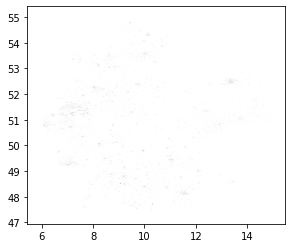

In [27]:
# Coverage
if manual: gpd.GeoDataFrame(sm.node_clusters).plot()

In [28]:
sm.links.sample()

,a,b,disaggregated_a,disaggregated_b,geometry,headway,link_sequence,route_id,route_type,route_type_disagg,time,trip_id
index,,,,,,,,,,,,
bus_1170290,b_DEA54_137,b_DEA54_73,bus_n_104705,bus_n_203988,"LINESTRING (7.90217 51.60469, 7.90078 51.62181)",43200.0,12.0,bus_17609,bus,bus,60.0,bus_17609_3


In [29]:
sm.links.shape

(2217231, 12)

## Clean
And map nodes to zones

In [30]:
# Map nodes to zones
sm.nodes = gpd.GeoDataFrame(sm.nodes, crs=sm.epsg)
shapely.speedups.enable()
sm.nodes['FID'] = np.nan
for _, zone in tqdm(sm.zones.iterrows(), total=sm.zones.shape[0]):
    sm.nodes.loc[sm.nodes['geometry'].within(zone['geometry'].buffer(1e-3)), 'FID'] = zone['NUTS_ID']
len(sm.nodes[sm.nodes['FID'].isna()])

100%|████████████████████████████████████████████████████████████████████████████████| 401/401 [13:34<00:00,  2.03s/it]


1

In [31]:
# Repair link geometry
geo_dict = sm.nodes['geometry'].to_dict()
sm.links['geometry'] = [geometry.LineString((geo_dict[a].coords[0], geo_dict[b].coords[0]))
                        for a,b in sm.links[['a', 'b']].values]

In [32]:
# Drop trips with different IDs but same stop sequences
s = sm.links.groupby('trip_id').agg(tuple).drop_duplicates('a', keep='first')
sm.links = sm.links.loc[sm.links['trip_id'].isin(s.index)]
sm.links.shape

(2151360, 12)

In [33]:
# Remove within-cluster links
# Neglect time savings when small cluster distances applied
def fix_circular(trip):
    drops = trip.loc[trip['a']==trip['b']].index
    if len(drops) > 0:
        trip = trip.drop(drops).sort_values('link_sequence')
        trip['link_sequence'] = list(range(1, len(trip)+1))
    return trip

In [34]:
sm.links = sm.links.groupby('trip_id').progress_apply(fix_circular).reset_index(level=0, drop=True)
sm.links.shape

100%|█████████████████████████████████████████████████████████████████████████| 145894/145894 [17:03<00:00, 142.58it/s]


(2039935, 12)

In [35]:
# Again: Drop trips with different IDs but same stop sequences
s = sm.links.groupby('trip_id').agg(tuple).drop_duplicates('a', keep='first')
sm.links = sm.links.loc[sm.links['trip_id'].isin(s.index)]
sm.links.shape

(2002539, 12)

In [24]:
# Convert the coordinate system back
sm = sm.change_epsg(4326, 'degree')

Reprojecting model from epsg 3857 to epsg 4326: 100%|██████████████████████████████████| 39/39 [04:46<00:00,  7.34s/it]


In [37]:
# Integrity tests
try:
    sm.integrity_test_nodeset_consistency()
except AssertionError:
    print('Number of orphan nodes: {}'.format(
        len(sm.orphan_nodes)))
    print('Number of missing nodes: {}'.format(
        len(sm.missing_nodes)))
sm.links.groupby('trip_id').apply(test_sequences)

Number of orphan nodes: 15
Number of missing nodes: 0


""


In [ ]:
# Drop orphan nodes
if len(sm.orphan_nodes) > 0: sm.nodes = sm.nodes.drop(sm.orphan_nodes)

In [52]:
# Test circular trips
circular = sm.links.groupby('trip_id').progress_apply(test_circular)
print('Number of links in circular trips: '+str(len(circular)))
print('Number of bus links in circular trips: '+str(len(circular.loc[circular['route_type']=='bus'])))

100%|████████████████████████████████████████████████████████████████████████| 143382/143382 [01:49<00:00, 1305.80it/s]

374641


In [58]:
# Remove circular lines
sm.links = sm.links.loc[~sm.links['trip_id'].isin(circular['trip_id'].unique())]
sm.links.shape

(1627898, 12)

In [59]:
sm.links.drop(['disaggregated_a', 'disaggregated_b'], axis=1, inplace=True)
len(sm.links.loc[sm.links.isna().any(axis=1)])

0

In [60]:
# Add bus service to ancilliary
sm.agencies = sm.agencies.append(bus.agencies).reset_index(drop=True)
sm.pt_routes = sm.pt_routes.append(bus.pt_routes).reset_index(drop=True)

In [61]:
# Now, we have bus services in the same tables
sm.pt_route_types = list(sm.links['route_type'].unique())
sm.pt_route_types

['air', 'bus', 'coach', 'rail_long', 'rail_short']

In [62]:
sm.links.loc[sm.links['route_type']=='rail_short'].sample()

,a,b,geometry,headway,link_sequence,route_id,route_type,route_type_disagg,time,trip_id
index,,,,,,,,,,
rs_55711,rs_DE600_52,rs_DE600_46,"LINESTRING (9.90850 53.64761, 9.90662 53.63412)",3086.0,21.0,rs_70,rail_short,rail_short,180.0,rs_70_1


## Save model


In [63]:
# Cast columns to integer
cols = ['link_sequence', 'time', 'headway']
sm.links[cols] = sm.links[cols].astype(int)

In [64]:
# Split links in graph and auxiliary information
# for file sizes being compatible with github's size limit
cols = ['link_sequence', 'route_id', 'time', 'trip_id', 'headway']
auxiliary = sm.links[cols]
sm.links.drop(cols, axis=1, inplace=True)

In [65]:
# Saving model...
sm.to_json(model_path + 'de_pt_network_agg',
           only_attributes=['zones', 'links', 'nodes', 'pt_route_types'],
           encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 39/39 [04:30<00:00,  6.94s/it]


In [66]:
sm.to_json(model_path + 'de_pt_network_ancillary',
           only_attributes=['agencies', 'pt_routes', 'node_parenthood'],
           encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 39/39 [00:51<00:00,  1.33s/it]


In [67]:
# Save auxiliary information seperately
auxiliary['index'] = auxiliary.index
auxiliary.reset_index(drop=True, inplace=True)
auxiliary.to_json(model_path + 'de_pt_network_agg/links_quetzaldata.json')